# Evaluation of Health Policy with HISP_Linear Regression

### Description of the dataset for practical exercises
Impact Evaluation in Practice (second edition) and related technical companion uses a fictionalized case, the Health Insurance Subsidy Program (HISP) to illustrate many of the concepts and methods that are presented. While fictionalized, the HISP case is modelled after real-world examples of impact evaluations. One of the primary objectives of HISP is to reduce the burden of health-related out-of-pocket expenditures for low income households.
https://openknowledge.worldbank.org/bitstream/handle/10986/25030/9781464807794.pdf?sequence=2&isAllowed=y

### The HISP Dataset

The HISP dataset has the Stata format and is called “evaluation.dta”. The dataset is at the level of household and round. This means that one observation (row) captures information for one household either in the baseline (round 0) or in the follow-up survey (round 1). In other words, every household appears on two rows: one for the baseline and one for the follow-up survey. Exercises 1-5 use only the cross-sectional follow-up survey, while Exercise 6 uses the full panel data.

### Practical Exercise Topics:
* Exercise 1: Data Exploration
* Exercise 2: Regression (regress, teffects, areg)
* Exercise 3: Matching (cem, ebalance, probit, teffect nnmatch, teffect ipw/ipwra)
* Exercise 4: Instrument Variables (ivregress)
* Exercise 5: Regression Discountinuity Designs (rdrobust, rdplot)

# Set up

### Lauching stata from the jupyter notebook

In [1]:
%%capture
import stata_setup
import os
os.chdir('C:\Program Files\Stata17/utilities')
from pystata import config
config.init('mp');

### Initial set up of log file and load data

In [2]:
%%capture
%%stata
set more off, perm

# redirect to workplace
cd "C:\Users\USER\Desktop\Charlene\2022 Charlene at York\Evaluation of Health Policy\practical exercise"

# create log file
capture log close
log using "EHP_HISP_Charlene.log", replace

# load data
use "evaluation.dta", clear

# limit sample to the cross section of post-treatment data
drop if round==0

# Data exploration

### Conduct describtive statistic on the HISP dataset

In [3]:
%%stata

codebook, compact
codebook, notes


. 
. codebook, compact

Variable       Obs Unique      Mean       Min       Max  Label
-------------------------------------------------------------------------------
locality_i~r  9914    200  73.93444         1       200  Locality identifier
household_~r  9914   9914  8038.721         2     15778  Unique household id...
treatment_~y  9914      2  .5003026         0         1  Household is locate...
promotion_~y  9914      2  .5127093         0         1  Household is locate...
eligible      9914      2  .5677829         0         1  Household eligible ...
enrolled      9914      2   .299072         0         1  HH enrolled in HISP...
enrolled_rp   9914      2  .2933226         0         1  Household enrolled ...
poverty_in~x  9914   1961  56.78873  20.47913       100  Poverty Index 1-100
round         9914      1         1         1         1  Survey round (0 = b...
health_exp~s  9914   9621  16.85922         0  116.8306  Out of pocket healt...
age_hh        9914     75  47.16584   

         Unique values: 2                         Missing .: 0/9,914

            Tabulation: Freq.  Value
                        8,932  0
                          982  1

-------------------------------------------------------------------------------
indigenous        Head of household speaks an indigenous language (0=no, 1=yes)
-------------------------------------------------------------------------------

                  Type: Numeric (float)

                 Range: [0,1]                         Units: 1
         Unique values: 2                         Missing .: 0/9,914

            Tabulation: Freq.  Value
                        6,415  0
                        3,499  1

-------------------------------------------------------------------------------
hhsize                                   Number of household members (baseline)
-------------------------------------------------------------------------------

                  Type: Numeric (float)

                 Range: [

In [4]:
%%stata
describe
summ


. describe

Contains data from evaluation.dta
 Observations:         9,914                  Household Roster (households
                                                with completed interview)
    Variables:            22                  9 Sep 2016 11:03
                                              (_dta has notes)
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
locality_iden~r float   %9.0g                 Locality identifier
household_ide~r float   %9.0g                 Unique household identifier
treatment_loc~y float   %9.0g                 Household is located in treatment
                                                community (0=no, 1=yes)
promotion_loc~y float   %9.0g                 Household is located in promoted
                                             

### Create(rename) variable for treatment effect evaluation 

In [5]:
%%capture
%%stata

# create generic variable (y)
clonevar y=health_expenditures 
label var y "out of pocket health expenditure pc/pa"
clonevar d=enrolled 
label var d "Treatment"

# create potential outcome y0 and y1
clonevar y0=y 
replace y0=. if d==1
clonevar y1=y 
replace y1=. if d==0

# summarise outcome of the treated and control group
bysort d:summ y y0 y1
tabstat y y0 y1, by(d)

### Produce two-way density plots for distribution of outcomes


. 
. tw  kdensity y0, || kdensity y1,  ///
> title(Distibutions of the outcome) subtitle(Treated & controls) ///
> xtitle(y: health expenditure) ytitle(density) ylabel( , angle(horizontal)) //
> /
> legend(off) saving(histy, replace) 
file histy.gph saved

. graph export pdf_y.png, replace
file pdf_y.png written in PNG format

. 


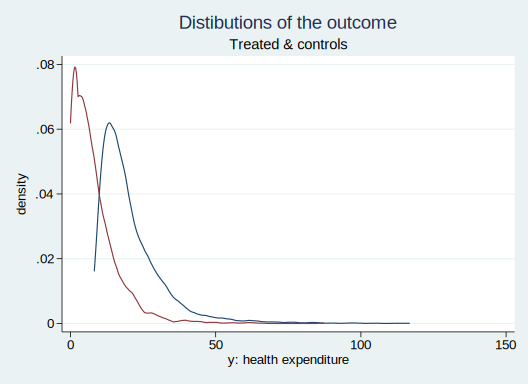

In [6]:
%%stata

tw  kdensity y0, || kdensity y1,  ///
title(Distibutions of the outcome) subtitle(Treated & controls) ///
xtitle(y: health expenditure) ytitle(density) ylabel( , angle(horizontal)) ///
legend(off) saving(histy, replace) 
graph export pdf_y.png, replace

The figure shows the density plots of the outcome for the treated and controls.

# Linear Regression

### Create global list of regressors

In [7]:
%%capture
%%stata

global xs "age_hh age_sp educ_hh educ_sp female_hh indigenous hhsize dirtfloor bathroom land hospital_distance" 

## Method 1: Commend teffects
### teffects
* teffect allows us to compute treatment effects directly using regression adjustment(ra).
* teffects: Treatment-effects estimation for observational data (POMs, ATEs,ATETs(ATT))

### Regression adjustment to est. ATT (ATET) (Average Treatment Effect of Treated) 

The average OPP is 9.8 dollor less when all the family who participate in the HISP program if they do not do so. 
<br>The average of 17.68 dollor would have occurred if none of those whom participate in the HISM participate had not do so.

In [8]:
%%stata

teffects ra (y $xs) (d), atet


. 
. teffects ra (y $xs) (d), atet

Iteration 0:   EE criterion =  3.215e-26  
Iteration 1:   EE criterion =  1.349e-30  

Treatment-effects estimation                    Number of obs     =      9,914
Estimator      : regression adjustment
Outcome model  : linear
Treatment model: none
------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATET         |
           d |
   (1 vs 0)  |  -9.837815    .169695   -57.97   0.000    -10.17041   -9.505219
-------------+----------------------------------------------------------------
POmean       |
           d |
          0  |   17.67799   .1313196   134.62   0.000     17.42061    17.93538
------------------------------------------------------------------------------

. 


### Regression adjustment to est. ATE (Average Treatment Effect) 

The average OOP if all participates in HISP program would be 10 dollor less than the average of 19.80 if none of the family had participate. <br>Note here that from the given calculation <b>"ATET=-9.83 ATE=-10.41"</b>, we know that the impact will be bigger if we condict treatment to all population than just treating the one in the treatment goup. 

In [9]:
%%stata

teffects ra (y $xs) (d), ate


. 
. teffects ra (y $xs) (d), ate

Iteration 0:   EE criterion =  3.215e-26  
Iteration 1:   EE criterion =  1.511e-30  

Treatment-effects estimation                    Number of obs     =      9,914
Estimator      : regression adjustment
Outcome model  : linear
Treatment model: none
------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
ATE          |
           d |
   (1 vs 0)  |  -10.41073   .2153258   -48.35   0.000    -10.83276   -9.988702
-------------+----------------------------------------------------------------
POmean       |
           d |
          0  |   19.80143   .1160521   170.63   0.000     19.57397    20.02889
------------------------------------------------------------------------------

. 


### Regression adjustment to the means of y0 and y1

The given commend allows us to see the average treatment effect(just to see where the base benchmark is)

In [10]:
%%stata

teffects ra (y $xs) (d), pomeans


. 
. teffects ra (y $xs) (d), pomeans

Iteration 0:   EE criterion =  3.215e-26  
Iteration 1:   EE criterion =  1.510e-30  

Treatment-effects estimation                    Number of obs     =      9,914
Estimator      : regression adjustment
Outcome model  : linear
Treatment model: none
------------------------------------------------------------------------------
             |               Robust
           y | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
POmeans      |
           d |
          0  |   19.80143   .1160521   170.63   0.000     19.57397    20.02889
          1  |   9.390699   .1926345    48.75   0.000     9.013142    9.768256
------------------------------------------------------------------------------

. 
